# Writing Julia Functions

The purpose of these notes is to introduce [R](http://www.r-project.org) programmers to the [Julia](http://julialang.org) programming language.

Julia functions are sufficiently similar to R functions that most R programmers can read most Julia functions.  They are sufficiently different that initial attempts at writing a Julia function can be frustrating.

One way of learning a programming language like Julia is to read programs written by experienced in that language.  One of the amazing aspects of Julia is that much of the Base system is written in Julia itself.  One of the current (June, 2014) deficiencies of Julia is that the documentation, especially package documentation, is quite sparse and you often need to read the source of a function to understand its purpose.

In these notes I am assuming the use of julia-0.4.2 or later.

In [1]:
versioninfo()

Julia Version 0.4.6
Commit 2e358ce (2016-06-19 17:16 UTC)
Platform Info:
  System: Linux (x86_64-unknown-linux-gnu)
  CPU: Intel(R) Core(TM) i5-3570 CPU @ 3.40GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


## Tools for examining functions

### Method signatures and sources

Entering the name of a function in R returns the definition of the function.  Entering the name of a function in Julia provides information on the number of methods defined for that generic.  Remember that all Julia functions are generic functions.

In [2]:
mean

mean (generic function with 4 methods)

The `methods` function gives the signatures of the methods for the generic.

In [3]:
methods(mean)

# 4 methods for generic function "mean":
mean{T<:Real}(r::Range{T<:Real}) at range.jl:710
mean(A::AbstractArray{T,N}) at statistics.jl:19
mean{T}(A::AbstractArray{T,N}, region) at statistics.jl:31
mean(iterable) at statistics.jl:6

In an IJulia notebook the names of the files are links to the file in the github repository.

Prebuilt binary packages for various operating systems may have a copy of the base directory elsewhere.  The Ubuntu binaries put it in `/usr/share/julia/base`

### The @which macro

In addition to functions Julia provides macros.  Writing macros is not a priority when you start but you should know about some of the macros that can be useful with regard to functions.  A call to a macro always begins with the `@` character and parenthesis around the argument list are optional.

For generics that have many methods (try `methods(*)`) it may not be obvious which method applies to a particular set of arguments.  The `@which` macro tells you which method will be used. 

In [4]:
@which mean([1:10;])

mean(A::AbstractArray{T,N}) at statistics.jl:19

In a REPL session the filenames will not be live links.  You can use `@less mean([1:10;])` to view the source file at the indicated location.

## Other useful macros

Two very useful macros for tuning the performance of your functions are `@time` and @profile.  Recent versions of the `@time` tell you the elapsed time, the total number of bytes allocated and the proportion of the time spent in garbage collection.

Note that the number of bytes allocated does not measure the increase in memory used by the process.  Often objects are allocated, populated, used and freed within the course of a functions's execution.

Also, bear in mind that the very short execution times are quite variable.

In [5]:
mean(randn((25,1_000_000)),1)  # 1,000,000 replications of a normal sample of size 25

1x1000000 Array{Float64,2}:
 -0.141432  -0.307227  -0.276117  …  -0.134498  0.0388967  -0.0461761

In [6]:
@time mn25n = mean(randn(25,1_000_000),1);

  0.154326 seconds (584 allocations: 198.398 MB, 2.17% gc time)


The first time a particular function signature is called it will be slower, often much slower, than subsequent times.  This is because the first call to a signature can cause a lot of compilation of methods.

Another useful macro is `@profile`, especially when paired with the `view` function in the `ProfileView` package.

In [7]:
@profile mean(randn(25,1_000_000),1);

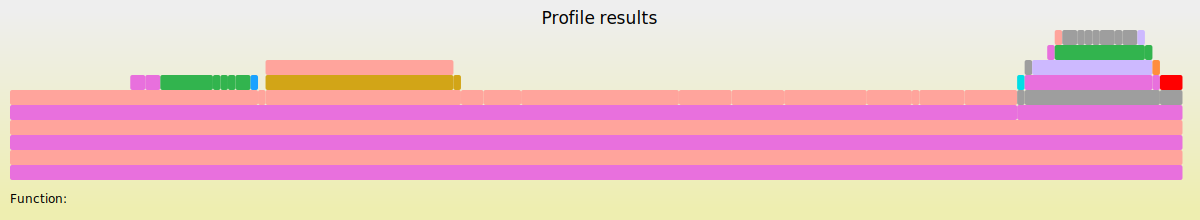

In [8]:
#Pkg.add("ProfileView") # similar to install.packages() in R
using ProfileView  # similar to library(ProfileView) in R
ProfileView.view()

In this case the results aren't very interesting but in a REPL session the bars in the image are live links to lines in the source code.

Note that using one package may bring in others.

In [9]:
whos()

                          Base  26878 KB     Module
                    ColorTypes    253 KB     Module
                        Colors    577 KB     Module
                        Compat    225 KB     Module
                          Core   4712 KB     Module
             FixedPointNumbers     32 KB     Module
                        IJulia   8189 KB     Module
                IPythonDisplay     27 KB     Module
                          JSON    232 KB     Module
                          Main  47285 KB     Module
                        Nettle     57 KB     Module
                   ProfileView    529 KB     Module
                ProfileViewSVG     17 KB     Module
                      Reexport   3628 bytes  Module
                           ZMQ     80 KB     Module
                         mn25n   7812 KB     1x1000000 Array{Float64,2}


## Simulation of the distribution of sample statistics

An example I like to use for function creation is simulation of the distribution of sample statistics.  For creating samples from various distributions we will use the Distributions package.  I was going to use the Gadfly package for visualization but it doesn't seem to be happy today.

In [10]:
# Pkg.add("Distributions") # done previously
using Distributions

In the last section, we simulated the means of samples of size 25 from a standard normal distribution.  We know that the distribution of this sample statistic should be a normal with mean zero and standard deviation 5.

In [11]:
mean(mn25n)  # expect a value close to zero

-7.607745026973842e-5

In [12]:
std(mn25n)  # expect a value close to 0.2

0.19998354641851948

The `randn` function for sampling from a normal distribution is in the `Base` module.  For other distributions we use the Distributions package.  Check the documentation for the Distributions package to see all the possibilities.

To write a general function for simulating the distribution of sample statistics we need the distribution from which to sample, the sample size, the statistic to evaluate and the number of replications to perform.  A distribution object encompasses both the distribution type and the parameters of the distribution.

In [13]:
typeof(Poisson)

DataType

In [14]:
methods(Poisson)

4-element Array{Any,1}:
 call(::Type{Distributions.Poisson}) at /home/bates/.julia/v0.4/Distributions/src/univariate/discrete/poisson.jl:25         
 call(::Type{Distributions.Poisson}, λ::Real) at /home/bates/.julia/v0.4/Distributions/src/univariate/discrete/poisson.jl:24
 call{T}(::Type{T}, arg) at essentials.jl:56                                                                                
 call{T}(::Type{T}, args...) at essentials.jl:57                                                                            

In [15]:
d = Poisson(5)

Distributions.Poisson(λ=5.0)

A function to replicate N times the evaluation of the statistic, s, on a sample of size n from distribution d can be written

In [16]:
function sampstat(N::Integer,s::Function,n::Integer,d::Distribution)
    samp = rand(d,n)   # simulate the first sample
    v1 = s(samp)       # evaluate the statistic
    res = Array(typeof(v1),(N,))  # create the result array
    res[1] = v1        # set the first element
    for i in 2:N
        res[i] = s(rand(d,n))
    end
    res
end

sampstat (generic function with 1 method)

It might be good to step through the evaluation just to check that everything is okay.

In [17]:
N = 100; n = 20; s = median

median (generic function with 43 methods)

In [18]:
samp = rand(d,n);
samp'

1x20 Array{Int64,2}:
 8  8  5  4  1  3  4  13  2  4  5  3  5  5  5  5  6  5  5  5

In [19]:
v1 = s(samp)

5.0

In [20]:
res = Array(typeof(v1),N);
res[1] = v1

5.0

In [21]:
for i in 2:N
    res[i] = s(rand(d,n))
end

In [22]:
res'

1x100 Array{Float64,2}:
 5.0  5.5  6.0  4.5  4.0  6.0  4.0  5.0  …  5.0  5.0  5.0  6.0  5.0  4.0  4.5

Next we generate a large sample and check the timing

In [23]:
@time med20p = sampstat(1_000_000,median,20,d);

  1.110126 seconds (6.01 M allocations: 572.455 MB, 7.03% gc time)


In [24]:
med20p'

1x1000000 Array{Float64,2}:
 4.0  4.0  5.0  5.0  4.0  4.0  4.5  5.0  …  4.5  2.5  5.0  5.0  4.0  5.5  4.0

We see that a large amount of storage is allocated and about 25% of the execution time is in garbage collection.  Because the function is fairly simple we can guess that the allocation is taking place in the call to `rand`.  For each of the 1,000,000 replications a new vector of 20 Int64 values is being allocated, populated, passed to the function `s` then released to be garbage collected later.

Julia allows for __mutating__ functions that change the value of one or more of their arguments.  This may seem heretical to R programmers but it can be very useful.  Tuning the performance of long-running functions often comes down to finding out where temporary storage is being allocated and avoiding doing that.

By convention, the names of mutating functions end in `!` so `rand` allocates new storage whereas `rand!` uses storage passed to it.  Fortunately the vector `samp` has already been allocated and we can reuse it.

In [25]:
samp'

1x20 Array{Int64,2}:
 8  8  5  4  1  3  4  13  2  4  5  3  5  5  5  5  6  5  5  5

In [26]:
rand!(d,samp)'

1x20 Array{Int64,2}:
 3  6  6  4  3  5  3  6  6  4  4  8  4  6  5  3  7  5  5  5

In [27]:
samp'

1x20 Array{Int64,2}:
 3  6  6  4  3  5  3  6  6  4  4  8  4  6  5  3  7  5  5  5

In [28]:
function sampstat1(N::Integer,s::Function,n::Integer,d::Distribution)
    samp = rand(d,n)   # simulate the first sample
    v1 = s(samp)       # evaluate the statistic
    res = Array(typeof(v1),(N,))  # create the result array
    res[1] = v1        # set the first element
    for i in 2:N
        res[i] = s(rand!(d,samp))
    end
    res
end

sampstat1 (generic function with 1 method)

In [29]:
@time med20p1 = sampstat1(1_000_000,s,n,d)'

  1.032929 seconds (5.00 M allocations: 366.426 MB, 2.46% gc time)


1x1000000 Array{Float64,2}:
 5.0  5.0  5.0  5.0  4.5  5.0  4.5  5.0  …  5.0  5.0  5.0  6.0  4.5  6.5  5.0

The reuse of the `samp` vector has helped to reduce the amount of storage allocated and the time spent in garbage collection but not substantially.  A less obvious source of allocation is the `median` function.  The non-mutating version must take a copy of the vector to do the (partial) sort evaluating the median.  We don't need to preserve the sample because we are going to overwrite it in the next iteration anyway.

In [30]:
@time med20p1 = sampstat1(1_000_000,median!,n,d)'

  0.967369 seconds (4.00 M allocations: 152.581 MB, 1.40% gc time)


1x1000000 Array{Float64,2}:
 6.0  5.0  5.0  5.0  5.0  6.0  5.0  4.0  …  4.0  6.5  6.0  4.0  5.0  5.0  4.0

We should, of course, check that the results are consistent by setting the random number generator seed and comparing the results from the two `sampstat` functions and the mutating and non-mutating `median` functions.

In [31]:
srand(1234321)
s1 = sampstat(100_000,median,n,d);
srand(1234321)
s2 = sampstat(100_000,median!,n,d);
srand(1234321)
s3 = sampstat1(100_000,median,n,d);
srand(1234321)
s4 = sampstat1(100_000,median!,n,d);
all(s1 .== s2 .== s3 .== s4)

true

## Syntax of function (actually method) definitions

We have seen that a method is defined by a block of the form
```
function <functionname>(arg1::Type1,arg2::Type2,...,argn::Typen)
   ...
end
```

Be careful not to let your R instincts take over and write
```
functionanme = function(arg1::Type1,...,argn::Typen)
 ...
end
```
That is not syntactically wrong but it isn't what you want. (The gory details are that it creates an anonymous function, which is generally less effective because of the way the compiler and type inference operates, then assigning this anonymous function to a name.)

The type annotations are optional.  Obviously when you are defining methods that are distinguished by the types of their arguments you use them.  Other times you may want to use them to validate the arguments.  In `sampstat` the argument `s` is applied as a function so it should be a function.  The argument `d` is passed to `rand` or `rand!` and it could be something other than a Distribution but we want a Distribution here.  It wouldn't make sense for `n` and `N` to be other than integers as they represent sizes.  The `Integer` type is an abstract type with several subtypes. 

In [32]:
typeof(Integer)

DataType

In [33]:
subtypes(Integer)

4-element Array{Any,1}:
 BigInt  
 Bool    
 Signed  
 Unsigned

Those coming to Julia with a background in strongly typed languages (C, C++, Java) tend to overspecify the argument types.  Generally I use argument type declarations when I want to distinguish methods and to validate the argument types.  Frequently in R I will begin a function with
```s
f <- function(a, b, c) {
   stopifnot(is.integer(a), length(a) == 1L, ...)
   ...
}
```
to validate the types of the actual arguments.  In Julia I specify the types that I want in the argument list.  If other types are passed the evaluation of the function fails to find an appropriate method.

The value of a function evaluation is the last object evaluated.  There is also a `return` directive which can be useful in short-circuiting evaluation.

A method that consists of a single expression can be written with an `=` sign.  For example, the `insupport` generic checks whether a value `x` is in the support of a distribution `d`.  The method for the Binomial type is
```julia
insupport(d::Binomial, x::Real) = isinteger(x) && 0 <= x <= d.size
```
If we want to check for all of a vector's elements being in the support we could write

In [34]:
function vsupport(d::Binomial,v::Vector)
    for el in v
        insupport(d, el) || return false
    end
    true
end

vsupport (generic function with 1 method)

Doing things this way if you have a million values to check and the second one fails you don't bother checking the rest.

An short anonymous function can be written with the "stabby lambda syntax".  To apply the logit transform to a vector of values in (0,1) we could write

In [35]:
μ = rand(10);
η = map(p -> log(p/(1-p)), μ);
using DataFrames
DataFrame(μ = μ, η = η)

,μ,η
1,0.0944217798994027,-2.260801891104243
2,0.9366111003876687,2.692979387335428
3,0.2583267373061602,-1.0546835920616155
4,0.9309236942019032,2.600965538110032
5,0.5552832964597973,0.22204096940697216
6,0.8715098619396013,1.9143750261699557
7,0.04155298306875843,-3.138344970491189
8,0.9687790528318041,3.4349473171034735
9,0.6535657113441573,0.6347499234293605
10,0.4581009073306117,-0.16799032669054131


Many of the reduction functions (`any`, `all`, `sum`, `prod`, etc.) can take a function as the first argument.  In that form `any` and `all` have the short-circuiting behavior so the `vsupport` function could be written

In [36]:
vsupport(d::Distribution, v) = any(x -> insupport(d, x), v)

vsupport (generic function with 2 methods)